# Easy 21 Reinforcement Learning

In this notebook, we are going to a Monte Carlo learning agent and a SARSA agent to play Easy 21, which is a modified version of blackjack. The rules for Easy 21 are as follows:
- Red and Black cards ranging from 1-10 in value
- Black cards are added to score, Red cards are subtracted from score
- Black cards occur with 2/3 probability, Red cards with 1/3 probability
- Agent and Dealer each start with 1 black card (agent can see dealer's card)
- Player can hit or stick on turn, once player sticks turn is over
- Agent goes first, then dealer
- Player with high score wins (bust if score > 21 or < 1)

(from: https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf)

In [3]:
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

### Initialization
First we need to set up our Agent class, which will play Easy 21 against a "dealer" who hits if he has between 1 and 17 and sticks otherwise. We can use the Agent class to run both the Monte Carlo simulation and the SARSA simulation.
The 3 actions we need to define for our Agent are:  
&nbsp;&nbsp;&nbsp;&nbsp;**step()** - the agent either hits and is dealt a card, or sticks and we play out the remainder of the dealer's turn  
&nbsp;&nbsp;&nbsp;&nbsp;**choose_action()** - follow the current policy with probability 1 - $\epsilon$ and explore (hit or stick randomly) with probability $\epsilon$  
&nbsp;&nbsp;&nbsp;&nbsp;**value_function()** - compute the best value for each possible state (agent total, dealer card)  
  
We also set up 3 functions to facilitate gameplay:  
&nbsp;&nbsp;&nbsp;&nbsp;**deal_card()** - Returns a black card with a random value between 1 and 10 with probability 2/3 and returns a red card with a random value between 1 and &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;10 with probability 1/3  
&nbsp;&nbsp;&nbsp;&nbsp;**is_terminal()** - Evaluates whether the agent or dealer has gone bust, or whether the agent has chosen to stick and the dealer has 17 or higher
&nbsp;&nbsp;&nbsp;&nbsp;**give_reward()** - Gives the agent a reward of 1 for a win, 0 for a non-terminal state or tie, and -1 for a loss

In [4]:
class Agent:
    def __init__(self, shape, epsilon=.9999, alpha=.1, gamma=.9):
        '''
        params: shape - ranges for player_sum, dealer_sum, num_actions for 
                        action/value approximation
                epsilon - exploration parameter
                alpha - step-size
                gamma - discount factor
                stick - boolean used to help determine if state is terminal
                values - action/value approximation
                running_total - agent score, used to calculate statistics for training runs
        '''
        self.stick = False
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.values = np.zeros((shape[0], shape[1], shape[2]))
        self.running_total = [0]
        
    def step(self, state, action):
        '''
        If player hits (0), deal card.  
        If player sticks (1), play out the dealer's turn
        '''
        if action == 0:
            state[0] += deal_card(False)
        else:
            self.stick = True
            while state[1] < 17 and state[1] >= 1:
                state[1] += deal_card(False)

        return give_reward(self, state)

    def choose_action(self, state, policy):
        greedy = np.random.random()
        if greedy > self.epsilon:
            action = policy[state[0] - 1][state[1] - 1]
        else:
            action = np.random.randint(2)
        return action
    
    def value_function(self):
        value_function = np.zeros((21,10))
        for i in range(len(self.values)):
            for j in range(len(self.values[i])):
                value_function[i][j] = np.max(self.values[i][j])
        return value_function   

In [5]:
def deal_card(is_first):
    '''
    First card for dealer and agent is black (positive value),
    for subsequent cards prob(black) = 2/3, prob(red) = 1/3
    '''
    value = np.random.randint(1,11)
    if is_first:
        return value
    else:
        color = np.random.random()
        if color < .33:
            value = 0 - value
        return value

In [6]:
def is_terminal(state, agent):
    if state[0] > 21 or state[0]< 1:
        return True

    elif agent.stick and (state[1] >= 17 or state[1] < 1):
        return True

    return False

In [7]:
def give_reward(agent, state):
    '''
    Reward = +1 (win), -1 (loss), 0 (tie or non-terminal state)
    '''
    if is_terminal(state, agent):
        if state[0] > 21 or state[0] < 1:
            agent.running_total.append((agent.running_total[-1] - 1))
            return -1
        elif state[1] > 21 or state[1] < 1:
            agent.running_total.append((agent.running_total[-1] + 1))
            return 1
        elif state[0] > state[1]:
            agent.running_total.append((agent.running_total[-1] + 1))
            return 1
        elif state[0] < state[1]:
            agent.running_total.append((agent.running_total[-1] - 1))
            return -1
    return 0

## Monte Carlo Agent
Monte Carlo learning is a type of model-free learning. That is to say, our Monte Carlo agent does not attempt to learn anything about the probability of transitioning between pairs of states. It simply tracks its average reward received from each action sequence. An action sequence here is a start state, an action (hit or stick), a reward, and the resulting next state. This is plain and simple learning from experience - over time the agent will learn whether hitting or sticking tends to yield higher reward for each state (player sum, dealer showing). Since Easy 21 involves a good bit of chance, both hitting and sticking may have negative average reward (picture yourself dealt a 14 in blackjack with the dealer showing an ace) so the agent will pick the most positive or least negative action in each state.

In [8]:
def monte_carlo(agent, num_episodes):
    '''
    Monte Carlo sampling run.  Action/value approximation: Q(s,a) = avg_return(s,a) 
    ε starts high to encourage exploration, steadily decreases as agent 
    learns better value approximations.  Policy starts as "hit" in every state, 
    becomes ε-greedy w.r.t. value function.
    '''
    policy = [[0 for i in range(10)] for i in range(21)]
    returns = [[[[],[]] for i in range(10)] for i in range(21)]

    for i in range(num_episodes):
        agent.stick = False
        agent.epsilon *= .9999
        G = 0
        state = [deal_card(True), deal_card(True)]
        while not is_terminal(state, agent):
            last_state = deepcopy(state)
            action = agent.choose_action(state, policy)
            reward = agent.step(state, action)
            G += reward
            returns[last_state[0] - 1][last_state[1] - 1][action].append(G)
            
            agent.values[last_state[0] - 1][last_state[1] - 1][action] = \
                np.average(returns[last_state[0] - 1][last_state[1] - 1][action])
            
            policy[last_state[0] - 1][last_state[1] - 1] = \
                np.argmax(agent.values[last_state[0] - 1][last_state[1] - 1])
    
    return policy
        

## SARSA Agent
SARSA stands for State-Action-Reward-State-Action, and is a form of Temporal Difference learning. Rather than waiting to receive the actual reward like the Monte Carlo agent, our SARSA agent will update its belief about its expected reward at each step. The update SARSA makes at each step is:  
$Q(s_t, a_t) = Q(s_t, a_t) + \alpha(r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$  
Where $Q(s_t, a_t)$ is the value function for the state-action pair $(s_t, a_t)$, $\alpha$ is the learning rate, or how heavily to value new information, and $\gamma$ is the discount rate, or how heavily to weight future vs. current rewards.

In [9]:
def sarsa(agent, num_episodes):
    '''
    SARSA Agent run.  Action/value approximation: 
    Q(s,a) = Q(s,a) + α(reward + γQ(s',a') - Q(s,a))
    ε held constant, policy starts as "hit" in all states,
    becomes ε-greedy w.r.t value function.
    '''
    policy = [[0 for i in range(10)] for i in range(21)]
    for i in range(num_episodes):
        agent.stick = False
        state = [deal_card(True), deal_card(True)]
        action = agent.choose_action(state, policy)
        while not is_terminal(state, agent):
            last_state = deepcopy(state)
            last_action = action
            reward = agent.step(state, action)
            
            if not is_terminal(state, agent):
                action = agent.choose_action(state, policy)
                agent.values[last_state[0] - 1][last_state[1] - 1][last_action] += \
                    (agent.alpha * (reward + (agent.gamma * \
                    agent.values[state[0] - 1][state[1] - 1][action]) - \
                    agent.values[last_state[0] - 1][last_state[1] - 1][last_action]))
            else:
                agent.values[last_state[0] - 1][last_state[1] - 1][last_action] += \
                    (agent.alpha * (reward - \
                    agent.values[last_state[0] - 1][last_state[1] - 1][last_action]))

            policy[last_state[0] - 1][last_state[1] - 1] = \
                np.argmax(agent.values[last_state[0] - 1][last_state[1] - 1])
            
    return policy

In [10]:
def plot_value_function(val):
    '''
    plotting function from: https://github.com/mari-linhares/easy21/blob/master/easy21.ipynb
    '''
    fig = plt.figure("Value Function", figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    min_x = 1
    max_x = 10
    min_y = 1
    max_y = 21
    
    x_range = np.arange(min_x, max_x)
    y_range = np.arange(min_y, max_y)
    
    X, Y = np.meshgrid(x_range, y_range)
    
    def get_stat_val(x, y):
        return val[y, x]
    Z = get_stat_val(X, Y)
    
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)

In [64]:
def plot_training_run(agent):
    episodes = np.array([i for i in range(1, len(agent.running_total))])
    moving_avg = np.array(agent.running_total[1:]) / episodes
    plt.plot(episodes[1000:], moving_avg[1000:])
    plt.xlabel("Number of Episodes")
    plt.ylabel("Winning Percentage")
    plt.show()

## Monte Carlo Agent Training Run
We start with a very high epsilon to encourage exploration, and gradually move increase the frequency with which our agent chooses the "best" action throughout the run. The agent starts quite poorly, losing around 56% of the time. By episode 40,000 it has gotten back to even and continues to win more frequently as the run progreses

In [65]:
mc_agent = Agent([21,10,2])
policy = monte_carlo(mc_agent, 100000)

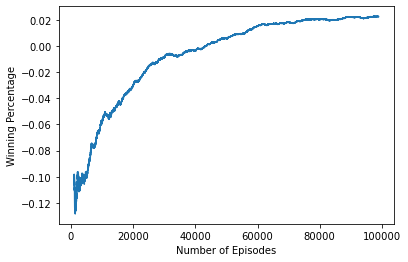

In [66]:
plot_training_run(mc_agent)

## Monte Carlo Agent Value Function
We can visualize the Monte Carlo agent's value function with matplotlib. This shows us the agent's expected reward for each state (player sum, dealer showing). Not surprisingly, states where the agent has close to a 20 have an expected value near 1 and states where the dealer is showing a high card or the agent has a lower sum has negative expected value.

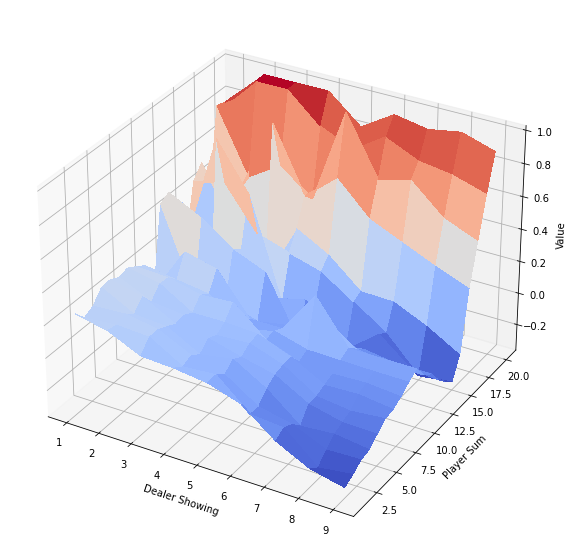

In [50]:
val = mc_agent.value_function()
plot_value_function(val)

## SARSA Agent Training Run
Our SARSA agent begins with a policy to hit in all states, and eventually updates its policy according to the value function. Like the Monte Carlo agent, the SARSA agent starts out quite poorly but begins to win more often quickly. The SARSA agent doesn't achieve quite the same performance overall as the Monte Carlo agent, but it learns much quicker as evidenced by the steep upwards slope very early in the plot.

In [67]:
sarsa_agent = Agent([21,10,2], .15)
sarsa_policy = sarsa(sarsa_agent, 500000)

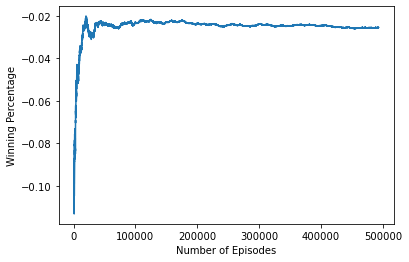

In [68]:
plot_training_run(sarsa_agent)

## SARSA Agent Value Function
Just like we did with the Monte Carlo agent, we can view the SARSA agent's value function. It is a little more jagged than the Monte Carlo agent's value function, but takes a similar shape.

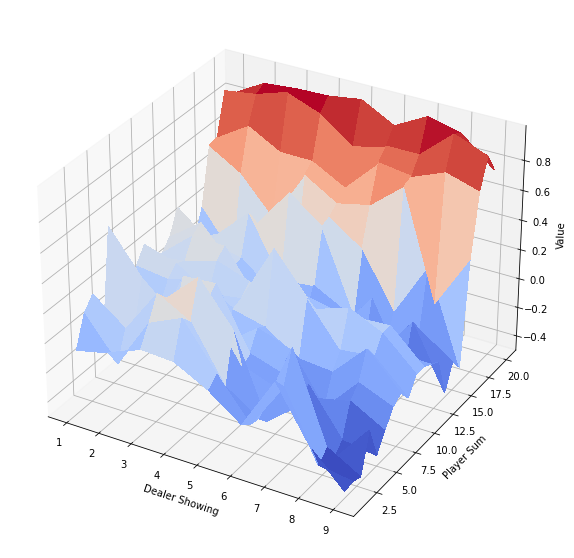

In [69]:
s_val = sarsa_agent.value_function()
plot_value_function(s_val)

## Mean Squared Error of SARSA Agent Value Function
Why did the SARSA agent not perform as well as the Monte Carlo agent? Likely because the Monte Carlo agent was basing its updates on the actual results, while the SARSA agent was keeping an approximation. This allowed the SARSA agent to learn quicker, but prevented from achieving the same level of performance. We can compute the Mean-Squared Error of the SARSA agent (taking the Monte Carlo agent's value function as ground truth) with the following formula:  
$MSE = \Sigma((Q(s,a)_{SARSA} - Q(s,a)_{Monte Carlo})^2$  

In [16]:
def compute_MSE(mc_agent, sarsa_agent):
    return np.sum((mc_agent.values - sarsa_agent.values)**2)

In [17]:
print(compute_MSE(mc_agent, sarsa_agent))

32.05236088134504
